# Questrade Portfolio Overview

In [1]:
import os
import math
import price
import requests
import questrade
from questrade import qbot
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import pandas_datareader.data as web
#from questrade_api import Questrade

In [2]:
questrade = qbot()

## Account Balance Summary

In [3]:
balance = questrade.get_balance()
balance

,Cash,Market_Value,Total_Equity,Cash (%),Investment (%)
Currency,,,,,
CAD,31785.3365,0.00,31785.3365,100.00,0.00
USD,21666.4215,10601.99,32268.4115,67.14,32.86


## Position & Performance Summary

In [4]:
portfolio = questrade.get_positions()

<AxesSubplot:title={'center':'Portfolio Breakdown'}, ylabel='%Portfolio'>

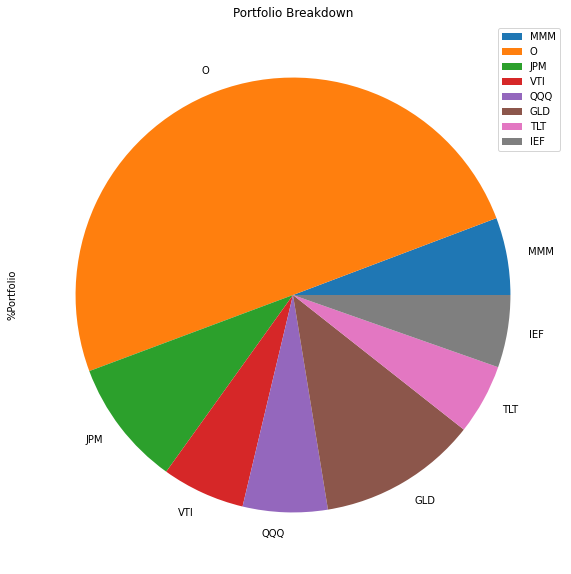

In [5]:
portfolio['%Portfolio'].plot(kind='pie',
                             title='Portfolio Breakdown',
                             figsize=(10, 10),
                             legend=True)

In [6]:
def color_negative_red(value):

    if value < 0:
        color = 'red'
    elif value > 0:
        color = 'green'
    else:
        color = 'black'

    return 'color: %s' % color

In [7]:
portfolio = portfolio.style.applymap(color_negative_red, subset=['Gain/Loss (%)'])
portfolio

,Description,Currency,Quantities,Market Value,Gain/Loss (%),%Portfolio
Symbol,,,,,,
MMM,3M COMPANY,USD,3,609.870000,3.260000,1.890000
O,REALTY INCOME CORP,USD,75,5295.750000,15.380000,16.410000
JPM,JPMORGAN CHASE & CO.,USD,6,996.360000,8.210000,3.090000
VTI,VANGUARD INDEX FUNDS VANGUARD TOTAL STOCK MARKET ETF,USD,3,655.410000,11.650000,2.030000
QQQ,INVESCO QQQ TRUST UNIT SER 1,USD,2,666.940000,4.310000,2.070000
GLD,SPDR GOLD TRUST GOLD SHARES NPV,USD,7,1251.390000,2.560000,3.880000
TLT,ISHARES TRUST BARCLAYS 20+ TREAS BD FD TO 07/01/2013,USD,4,554.120000,-8.660000,1.720000
IEF,ISHARES TRUST BARCLAYS 7-10 YEAR TREASURY BOND ETF,USD,5,572.150000,-3.550000,1.770000


## Monthly Dividend Income

In [12]:
div = questrade.get_dividend_income()
div.loc['Total'] = div.sum(numeric_only=True, axis=0)

<AxesSubplot:title={'center':'Monthly Dividend Payments'}, xlabel='Months', ylabel='Dividend ($)'>

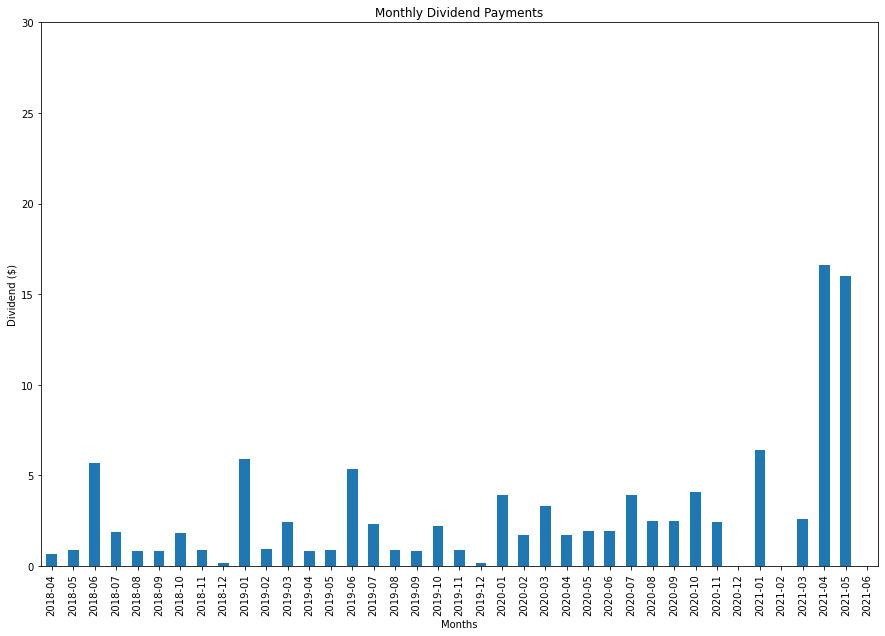

In [13]:
div[:-1].plot(kind='bar',
                    title='Monthly Dividend Payments',
                    xlabel='Months',
                    ylabel='Dividend ($)',
                    figsize=(15, 10),
                    legend=False,
                    ylim=(0, 30))

## Global Macro Momentum

global_macro = ['SPY', 'QQQ', 'TLT', 'IEF', 'GLD', 'DBC']
period = [1,3,6,12,24,36,48,60]

data = {'Symbol': [], 'Momentum': []}
count = 0
for symbol in global_macro:
    count += 1
    print(f"{count}/{len(global_macro)}")
    data['Symbol'].append(symbol)
    data['Momentum'].append(momentum.calculate_equal_weight_momentum(symbol, period))
momentum_df = pd.DataFrame(data)
momentum_df.set_index('Symbol')
momentum_df.sort_values(by='Momentum',inplace=True, ascending=False)
momentum_df

## US Sector Momentum

sector_df = pyticker.get_sector_df()
period = [1,3,6,12]
count = 0
for x in list(sector_df.index):
    count += 1
    print(f"{count}/{len(list(sector_df.index))}")
    sector_df.loc[x,'Momentum'] = momentum.calculate_equal_weight_momentum(x, period)

sector_df.sort_values(by='Momentum', inplace=True, ascending=False)
sector_df